In [36]:
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(broom)
options(repr.matrix.max.rows = 6)

In [69]:
raisin_data <- read_csv("https://raw.githubusercontent.com/radmantvk/DSCI-Project/main/Raisin_Dataset.csv") %>%
    mutate(Class = as_factor(Class))
raisin_data

Parsed with column specification:
cols(
  Area = col_double(),
  MajorAxisLength = col_double(),
  MinorAxisLength = col_double(),
  Eccentricity = col_double(),
  ConvexArea = col_double(),
  Extent = col_double(),
  Perimeter = col_double(),
  Class = col_character()
)



Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
99657,431.7070,298.8373,0.7216841,106264,0.7410985,1292.828,Besni
93523,476.3441,254.1761,0.8457385,97653,0.6587983,1258.548,Besni
85609,512.0818,215.2720,0.9073454,89197,0.6320200,1272.862,Besni


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



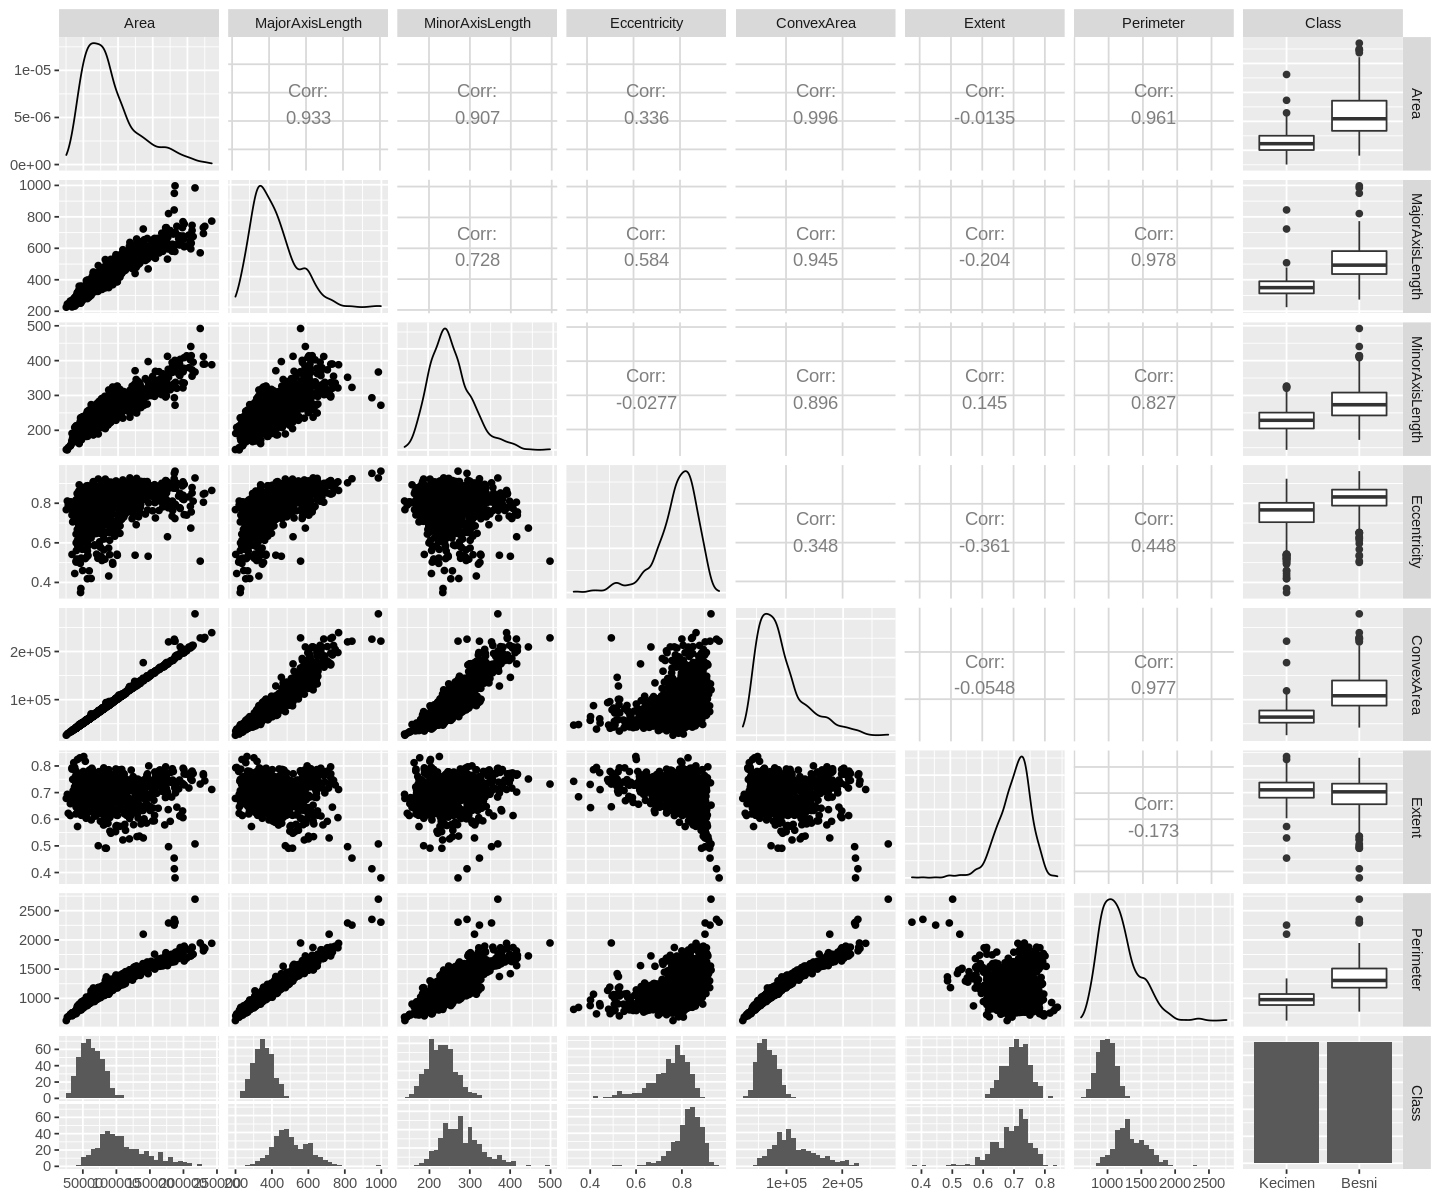

In [70]:
options(repr.plot.width = 12, repr.plot.height = 10)
raisin_pair <- ggpairs(raisin_data)
raisin_pair

In [71]:
options(repr.plot.width = 6, repr.plot.height = 5)
raisin_plot1 <- raisin_data %>%
    ggplot(aes(x = MajorAxisLength, y = MinorAxisLength, color = Class)) + 
    geom_point(alpha = 0.5) +
    labs(x = "Major Axis Length", y = "Minor Axis Length", color = "Type") +
    ggtitle("Major vs. Minor Axes Lengths") + 
    theme(text = element_text(size=22))

raisin_plot2 <- raisin_data %>%
    ggplot(aes(x = Perimeter, y = ConvexArea, color = Class)) + 
    geom_point(alpha = 0.5) +
    labs(x = "Perimeter", y = "ConvexArea", color = "Type") +
    ggtitle("Perimeter vs. ConvexArea") + 
    theme(text = element_text(size=22))

raisin_plot3 <- raisin_data %>%
    ggplot(aes(x = Perimeter, y = Area, color = Class)) + 
    geom_point(alpha = 0.5) +
    labs(x = "Perimeter", y = "Area", color = "Type") +
    ggtitle("Perimeter vs. Area") + 
    theme(text = element_text(size=22))

raisin_plot4 <- raisin_data %>%
    ggplot(aes(x = Perimeter, y = MajorAxisLength, color = Class)) + 
    geom_point(alpha = 0.5) +
    labs(x = "Perimeter", y = "Major Axis Length", color = "Type") +
    ggtitle("Perimeter vs. Major Axis Length") + 
    theme(text = element_text(size=22))

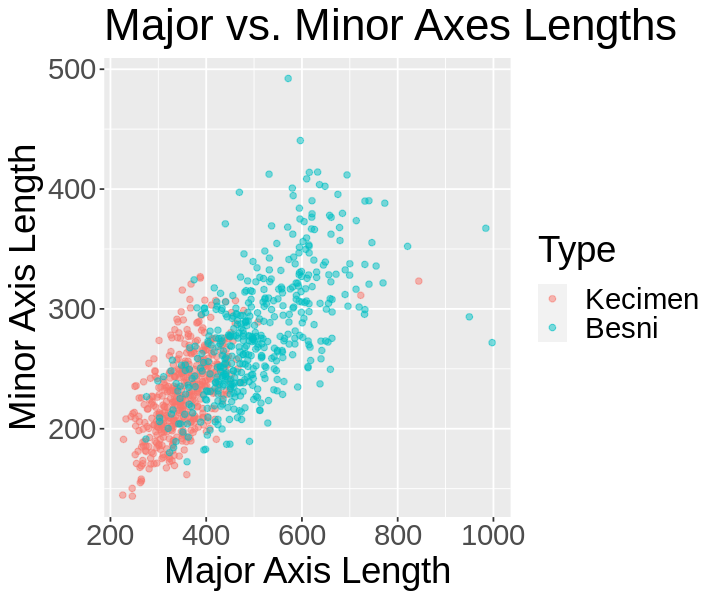

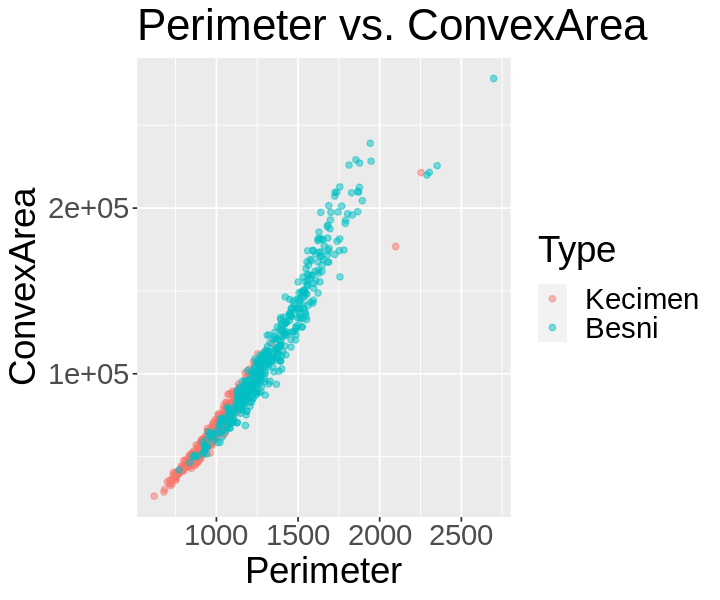

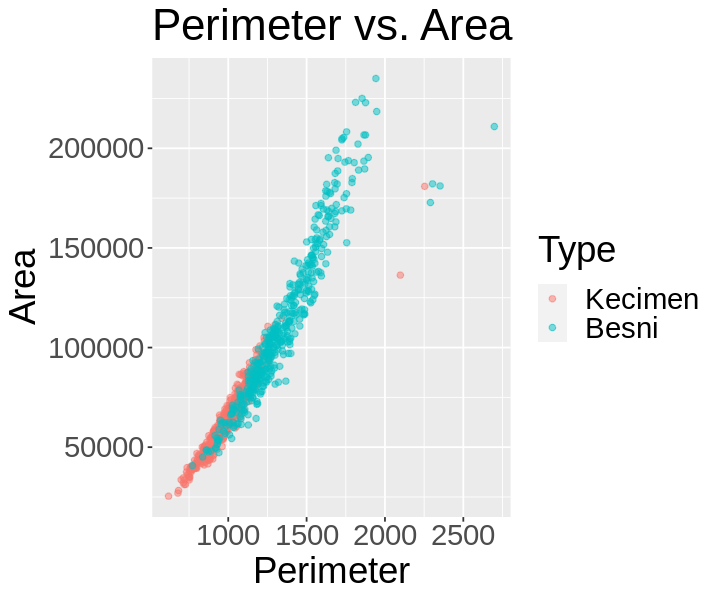

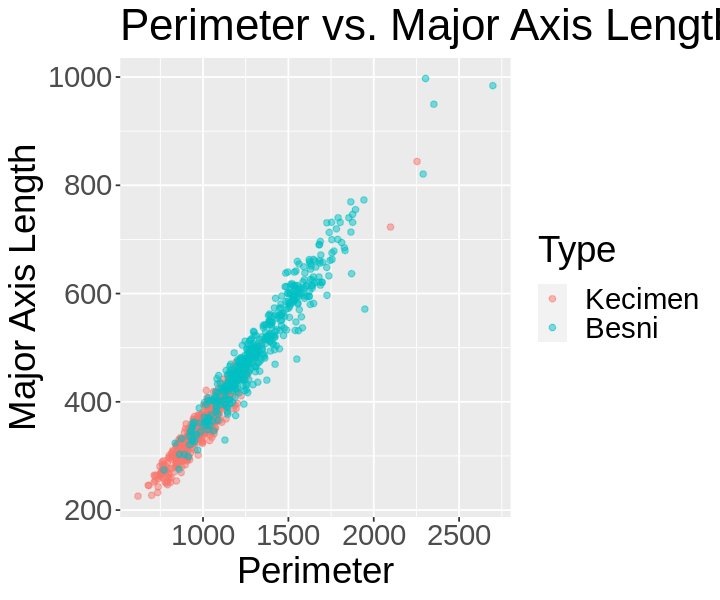

In [72]:
raisin_plot1
raisin_plot2
raisin_plot3
raisin_plot4

In [73]:
#splitting data

raisin_data <- raisin_data %>%
    select(MajorAxisLength, MinorAxisLength, Class)

raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)
raisin_train <- training(raisin_split)
raisin_test <- testing(raisin_split)

#model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

recipe <- recipe(Class ~ ., data = raisin_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_vfold <- vfold_cv(raisin_train, v = 5, strata = Class)

gridvals <- tibble(neighbors = seq(from = 1, to = 50))

knn_fit <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = knn_vfold, grid = gridvals)

accuracies <- knn_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")



#best_k <- accuracies %>%
#    slice()

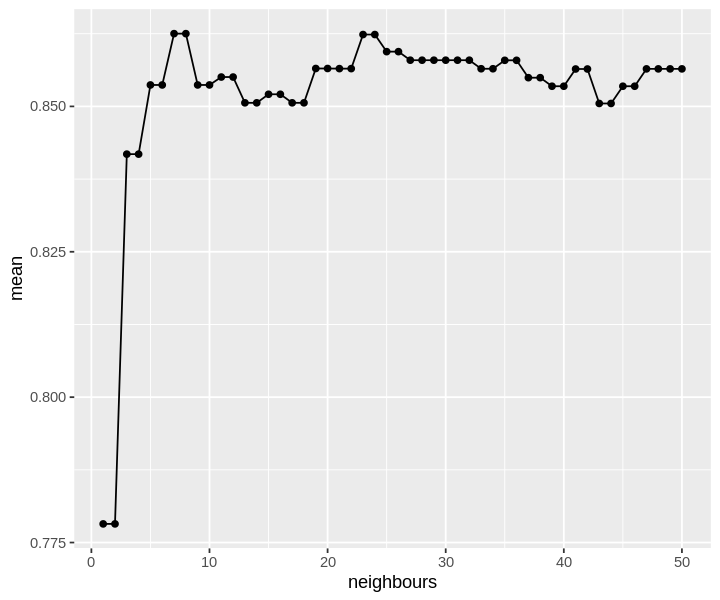

In [74]:
accuracies_plot <- accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "neighbours", y = "mean") 

accuracies_plot

In [75]:
k <- accuracies %>%
    arrange(desc(mean)) %>%
    slice(1) %>%
    select(neighbors) %>%
    pull()

k

[1] 7

In [79]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_best_spec) %>%
    fit(raisin_train)

prediction <- predict(knn_fit, raisin_test) %>%
    bind_cols(raisin_test)

metrics <- prediction %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()

prediction

metrics

.pred_class,MajorAxisLength,MinorAxisLength,Class
<fct>,<dbl>,<dbl>,<fct>
Besni,449.4546,232.3255,Kecimen
Kecimen,338.8575,291.3592,Kecimen
Kecimen,261.5543,167.7085,Kecimen
⋮,⋮,⋮,⋮
Besni,507.6851,268.0873,Besni
Kecimen,356.5678,253.2547,Besni
Besni,511.4720,291.5913,Besni


[1] 0.8080357